<a href="https://colab.research.google.com/github/tjturnage/Google-Colab_Notebooks/blob/main/AFDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size='4.5em' color='#aaaa00'>To run this colab notebook, select your preferences in each cell. Click the "play" button to run each cell in sequence.</font>

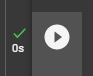

<font size='4.5em' color='#aaaa00'>
Wait for a cell to complete successfully before proceeding to the next one.</font>


<font size='4.5em' color='#6666ff' style='bold' text-align='center'>Enter the three letter ID of your WFO below</font>

---



In [ ]:
import re
from datetime import datetime
import requests
from bs4 import BeautifulSoup

wfo = "APX" #@param {type:"string"}

try:
  url = f'https://forecast.weather.gov/product.php?site={wfo}&issuedby={wfo}&product=AFD&format=ci&version=1&glossary=0'
  page = requests.get(url, timeout=5)
  soup = BeautifulSoup(page.content, 'html.parser')
  afd_text = str(soup.pre)
  print(f'{wfo} is your selected WFO.')
except:
  print(f'Unable to access AFDs from {wfo}! Ensure your id is correct!')


APX is your selected WFO.


<font size='4.5em' color='#6666ff' style='bold'>Use the drop down menu to Select the number of AFDs you want to retrieve:</font>
<hr>

In [ ]:
number_of_afds = 45 #@param ["5", "10", "15", "20", "25", "30", "35", "40", "45", "50"] {type:"raw"}


<font size='4.5em' color='#6666ff' style='bold'>Select the AFD sections you want to extract:</font>
<hr>

In [ ]:
update = True #@param {type:"boolean"}
synopsis = False #@param {type:"boolean"}
short_term = True #@param {type:"boolean"}
long_term = True #@param {type:"boolean"}
discussion = False #@param {type:"boolean"}
aviation = False #@param {type:"boolean"}
fire_weather = False #@param {type:"boolean"}
hydrology = False #@param {type:"boolean"}
marine = False #@param {type:"boolean"}
climate = False #@param {type:"boolean"}


sections_to_retrieve = []
if update:
  sections_to_retrieve.append('.UPDATE')
if synopsis:
  sections_to_retrieve.append('.SYNOPSIS')
if short_term:
  sections_to_retrieve.append('.SHORT TERM')
if long_term:
  sections_to_retrieve.append('.LONG TERM')
if discussion:
  sections_to_retrieve.append('.DISCUSSION')
if aviation:
  sections_to_retrieve.append('.AVIATION')
if fire_weather:
  sections_to_retrieve.append('.FIRE WEATHER')
if hydrology:
  sections_to_retrieve.append('.HYDROLOGY')
if marine:
  sections_to_retrieve.append('.MARINE')
if climate:
  sections_to_retrieve.append('.CLIMATE')


print(f'You selected: {sections_to_retrieve}')

You selected: ['.UPDATE', '.SHORT TERM', '.LONG TERM']


<hr>   

<font size='4.5em' color='#6666ff' style='bold'>Run the final cell below, and then scroll down past it once it completes.</font>   
<hr>

In [ ]:
output_path = 'afds.txt'
    
class AFD:
    def __init__(self,wfo,versions=50):
        self.wfo = wfo
        self.versions = int(versions)
        if self.versions > 50:
            self.versions = 50
        self.section_dict = {}
        self.grab_bulletins()
        self.write_text()

    def get_time(self,line):
        """
        input:
            String: "Issued at" line (Ex: 'Issued at 307 AM EST Sat Dec 18 2021')
            return: datestring
            %I      7   Hour (12-hour clock) as a decimal number. (Platform specific)
            %M     06   Minute as a zero-padded decimal number.
            %p     AM   Locale’s equivalent of either AM or PM.
            %a    Sun   Weekday as locale’s abbreviated name.
            %b    Sep   Month as locale’s abbreviated name.
            %-d     8   Day of the month as a decimal number. (Platform specific)
            %Y   2013   Year with century as a decimal number.

        """
        #test = 'Issued at 1207 PM EST Sat Dec 8 2021'
        try:
          elements = line.split(" ")
          # remove the time zone and day of week because they don't matter
          extracted_elements = elements[2:4] + elements[6:]
          shortened_time_string = " ".join(extracted_elements)
          datetime_object = datetime.strptime(shortened_time_string, '%I%M %p %b %d %Y')
          new_datetime_string = datetime.strftime(datetime_object, '%Y%m%d%H%M')
        except:
          new_datetime_string = "ZZZZ_Missing"

        return new_datetime_string


    def get_forecaster_id(self,afd_text,section_name):
        """

        """
        buffer = '  --------------------------  '
        section_name_minus_leading_period = section_name[1:]
        forecaster_id_section = afd_text.split('$$')[-1]
        id_lines = forecaster_id_section.splitlines()
        fcstr = 'None found'
        for line in id_lines:
          if section_name_minus_leading_period in line:
            fcstr = str(line.split("...")[1])    
            final = f'\n\n{buffer}{fcstr}{buffer}\n\n'
            break

        return final
      


    def get_section(self,afd_text,section_name):
      """

      """    
      datetime_string = "ZZZZ_Missing"
      try:
        section_text = afd_text.split(section_name)[1]
      except:
        return
      
      issuance_time_string = self.get_time(section_text)

      try:
        forecaster_id = self.get_forecaster_id(afd_text,section_name)
      except:
        print('forecaster id missing!')


      section_data = []
      for line in section_text.splitlines():
        if '&amp;&amp;' in line:
          break
        elif '$' in line:
          break
        elif '.LONG TERM' in line:
          break
        else:
          if 'Issued at' in line:
            datetime_string = self.get_time(line)
            section_data.append(line)
          else:
            section_data.append(line)

      section_content = '\n'.join(section_data)
      unique_section_identifier = f'{datetime_string}_{section_name}'
      final_section_text = f'{forecaster_id}{section_name}{section_content}'
      self.section_dict[unique_section_identifier] = final_section_text
      return


    def grab_bulletins(self):
        for version in range(1,self.versions):
            url = f'https://forecast.weather.gov/product.php?site={wfo}&issuedby={wfo}&product=AFD&format=ci&version={version}&glossary=0'
            page = requests.get(url, timeout=5)
            soup = BeautifulSoup(page.content, 'html.parser')
            afd_text = str(soup.pre)
            for section in sections_to_retrieve:
                self.get_section(afd_text, section)

        return

    def write_text(self):
      with open('afds.txt','w') as fout:
        for value in self.section_dict.values():
          fout.write(value)

        
if __name__ == '__main__':
    test = AFD(wfo, number_of_afds)


<font size='4.5em' color='#6666ff' style='bold'>Click the folder icon to the left to reveal a file called "afds.txt". Double-click to view or right-click to download.</font>
<hr>   

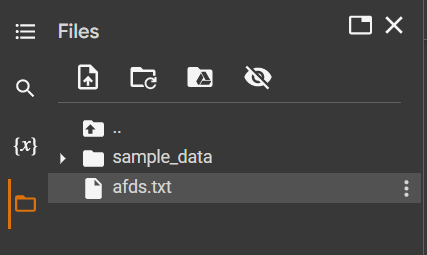   

<hr>

<font size='4em' color='#6666ff' style='bold'>AFD sections will be listed in the text file with the most recent issuance at the top.</font>
   
<font size='3.5em' color='cc99cc'>In the example below, forecaster ABC wrote the SHORT TERM section.</font>
<hr>

```

  --------------------------  ABC  --------------------------  

.SHORT TERM...
(Today and tonight)
Issued at 330 AM CDT Mon Mar 20 2023

Our area will remain under high pressure today ...
```

 